# Generate Datasets

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
import warnings
import pandas as pd
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, generate_dataset, validate_dataset, evaluate_dqn_agent

In [2]:
SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

In [3]:
# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

Device: cuda


# AGENTs

In [ ]:
def make_eval_callback(save_dir, eval_env, eval_freq):
    return EvalCallback(
        eval_env=eval_env,
        best_model_save_path=save_dir,
        log_path=save_dir,
        eval_freq=eval_freq,
        n_eval_episodes=10,
        deterministic=True,
        verbose=1
    )

def train_dqn_agent(agent_name, total_timesteps, buffer_size, learning_starts, exploration_fraction, final_eps, eval_freq=100_000):
    print(f"\nTraining: {agent_name} | Steps: {total_timesteps} | Final Eps: {final_eps}")
    
    train_env = create_environment(env_id=ENV_ID, seed=SEED)
    eval_env = create_environment(env_id=ENV_ID, seed=SEED + 42)  # different seed for evaluation

    train_env = TimeLimit(train_env, max_episode_steps=10000)
    eval_env = TimeLimit(eval_env, max_episode_steps=10000)

    dqn = DQN(
        policy="CnnPolicy",
        env=train_env,
        learning_rate=1e-4,
        buffer_size=buffer_size,
        learning_starts=learning_starts,
        batch_size=32,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=1_000,
        exploration_fraction=exploration_fraction,
        exploration_initial_eps=1.0,
        exploration_final_eps=final_eps,
        device=device,
        seed=SEED,
        verbose=1
    )

    eval_cb = make_eval_callback(f"datasets/agent_checkpoints/{agent_name}", eval_env, eval_freq)
    dqn.learn(total_timesteps=total_timesteps, callback=eval_cb)
    
    # Save final model just in case
    dqn.save(f"datasets/dqn_seaquest_{agent_name}_final")
    print(f"Finished training {agent_name}")

    # Clean up
    train_env.close()
    eval_env.close()

In [5]:
%%time

# Beginner (undertrained, noisy)
train_dqn_agent("beginner_agent(300k)", total_timesteps=300_000, buffer_size=100_000, learning_starts=15_000, exploration_fraction=0.5, final_eps=0.65, eval_freq=50_000)

print("----- Execution time: Beginner Agent (DQN) | 300.000 Timesteps -----")


Training: beginner_agent(300k) | Steps: 300000 | Final Eps: 0.65
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2542     |
|    time_elapsed     | 4        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 87.5     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 777      |
|    time_elapsed     | 28       |
|    total_timesteps  | 22113    |
| train/              |          |
|    learning_rate    | 0.00

In [4]:
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

print(beginner_agent.num_timesteps)

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, beginner_agent, SEED, num_episodes=25)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01
300000


100%|██████████| 25/25 [03:06<00:00,  7.45s/it]

Average Reward over 25 episodes: 233.6
Action Counts: {13: 12059, 12: 92, 8: 17830, 6: 2416, 14: 1378, 0: 74771, 10: 969, 4: 2146, 5: 1312, 15: 16601, 3: 72, 17: 548, 11: 5607, 7: 83, 16: 1112, 2: 77, 1: 81, 9: 123}


In [5]:
%%time

# Intermediate (more stable)
train_dqn_agent("intermediate_agent(3M)", total_timesteps=3_000_000, buffer_size=150_000, learning_starts=15_000, exploration_fraction=0.2, final_eps=0.05)

print("----- Execution time: Intermediate Agent (DQN) | 3.000.000 Timesteps -----")


Training: intermediate_agent(3M) | Steps: 3000000 | Final Eps: 0.05
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3057     |
|    time_elapsed     | 3        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.63e+03 |
|    ep_rew_mean      | 85       |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 879      |
|    time_elapsed     | 23       |
|    total_timesteps  | 21045    |
| train/              |          |
|    learning_rate    | 0

In [7]:
intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

print(intermediate_agent.num_timesteps)

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, intermediate_agent, SEED, num_episodes=25)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01
1800000


100%|██████████| 25/25 [04:18<00:00, 10.34s/it]

Average Reward over 25 episodes: 663.2
Action Counts: {9: 254, 15: 462, 2: 68080, 12: 2671, 5: 904, 3: 2155, 17: 6083, 7: 534, 16: 44532, 4: 45632, 13: 25868, 14: 414, 10: 720, 11: 417, 1: 268, 6: 779, 8: 143, 0: 97}


In [5]:
%%time

# Expert (well-trained, with best performance)
train_dqn_agent("expert_agent(10M)", total_timesteps=10_000_000, buffer_size=100_000, learning_starts=50_000, exploration_fraction=0.1, final_eps=0.01)

print("----- Execution time: Expert Agent (DQN) | 10.000.000 Timesteps -----")


Training: expert_agent(10M) | Steps: 10000000 | Final Eps: 0.01
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3058     |
|    time_elapsed     | 3        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 95       |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3578     |
|    time_elapsed     | 6        |
|    total_timesteps  | 23297    |
----------------------------------
-----------------------------

In [4]:
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)
print(expert_agent.num_timesteps)  # How far was this model trained?

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, expert_agent, SEED, num_episodes=25)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
4900000


100%|██████████| 25/25 [03:36<00:00,  8.67s/it]

Average Reward over 25 episodes: 1044.0
Action Counts: {6: 9714, 15: 11914, 5: 6572, 12: 21177, 16: 17202, 13: 10082, 7: 9487, 3: 24946, 11: 14360, 4: 1887, 14: 8988, 2: 10371, 9: 12245, 17: 3976, 0: 1448, 10: 1372, 8: 5538, 1: 1238}


## Beginner Dataset (most random)

In [4]:
# load the agent
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01


### 0%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb0.pkl'

seaquest_beginner_perturb0 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 155813
Number of perturbed actions: 0
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb0.pkl


### 5%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb5.pkl'

seaquest_beginner_perturb5 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 156685
Number of perturbed actions: 8009
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb5.pkl


### 10%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb10.pkl'

seaquest_beginner_perturb10 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 153047
Number of perturbed actions: 15605
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb10.pkl


### 20%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb20.pkl'

seaquest_beginner_perturb20 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 153129
Number of perturbed actions: 30759
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb20.pkl


## Intermediate Dataset (less random, more stable)

In [4]:
# load the agent
intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01


### 0%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb0.pkl'

seaquest_intermediate_perturb0 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 158185
Number of perturbed actions: 0
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb0.pkl


### 5%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb5.pkl'

seaquest_intermediate_perturb5 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 157273
Number of perturbed actions: 8039
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb5.pkl


### 10%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb10.pkl'

seaquest_intermediate_perturb10 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 158089
Number of perturbed actions: 16093
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb10.pkl


### 20%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb20.pkl'

seaquest_intermediate_perturb20 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 156717
Number of perturbed actions: 31457
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb20.pkl


## Expert Dataset (most stable)

In [2]:
# load the agent
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)

print("Exploration rate after training:", expert_agent.exploration_rate)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.01


### 0%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent (self trained agent, for 10M steps)
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb0.pkl'

seaquest_expert_perturb0 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 150305
Number of perturbed actions: 0
Dataset saved to datasets/expert_logs\seaquest_expert_perturb0.pkl


### 5%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent (self trained agent, for 10M steps)
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb5.pkl'

seaquest_expert_perturb5 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 150697
Number of perturbed actions: 7689
Dataset saved to datasets/expert_logs\seaquest_expert_perturb5.pkl


### 10%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent (self trained agent, for 10M steps)
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb10.pkl'

seaquest_expert_perturb10 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 154171
Number of perturbed actions: 15709
Dataset saved to datasets/expert_logs\seaquest_expert_perturb10.pkl


### 20%

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, analyze_action_distribution, generate_dataset, validate_dataset, evaluate_dqn_agent

# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# load the agent (self trained agent, for 10M steps)
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)

Device: cuda
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb20.pkl'

seaquest_expert_perturb20 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 152087
Number of perturbed actions: 30546
Dataset saved to datasets/expert_logs\seaquest_expert_perturb20.pkl


# check datasets

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_dataset(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def inspect_dataset(dataset, verbose=True):
    total_transitions = len(dataset)
    num_perturbed = 0
    action_counts = {}
    episodes = 0

    for t in dataset:
        if len(t) != 8:
            raise ValueError("Expected 8-tuple dataset (obs, action, reward, next_obs, next_action, done, perturbed, original_action)")

        obs, action, reward, next_obs, next_action, done, perturbed, original_action = t

        if perturbed:
            num_perturbed += 1

        if done:
            episodes += 1

        # Count original actions for a cleaner skill analysis
        action_counts[original_action] = action_counts.get(original_action, 0) + 1

    if verbose:
        print(f"Total transitions            : {total_transitions}")
        print(f"Number of episodes (done=True): {episodes}")
        print(f"Unique original actions       : {sorted(action_counts.keys())}")
        print(f"Action counts (original)      : {action_counts}")
        print(f"Number of perturbed actions   : {num_perturbed}")
        print(f"Perturbation rate             : {num_perturbed / total_transitions:.3%}")

    return {
        'length': total_transitions,
        'episodes': episodes,
        'action_distribution': action_counts,
        'perturbed': num_perturbed
    }


def plot_perturbation_heatmap(dataset, action_size=18):
    original = []
    perturbed = []

    for t in dataset:
        if len(t) != 8:
            raise ValueError("Expected 8-tuple format for perturbation plotting.")
        
        _, action, _, _, _, _, is_perturbed, original_action = t

        if is_perturbed:
            original.append(original_action)
            perturbed.append(action)

    heatmap = np.zeros((action_size, action_size), dtype=int)

    for o, p in zip(original, perturbed):
        heatmap[o][p] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=range(action_size), yticklabels=range(action_size))
    plt.xlabel("Perturbed Action")
    plt.ylabel("Original Action")
    plt.title("Perturbed Action Mapping (Original → Perturbed)")
    plt.tight_layout()
    plt.show()



Total transitions            : 153047
Number of episodes (done=True): 24
Unique original actions       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Action counts (original)      : {13: 16249, 12: 119, 8: 16201, 6: 3080, 17: 1013, 14: 1596, 0: 77549, 10: 1494, 15: 19677, 11: 9880, 5: 1712, 3: 113, 4: 1759, 16: 2181, 2: 105, 9: 169, 7: 69, 1: 81}
Number of perturbed actions   : 15605
Perturbation rate             : 10.196%


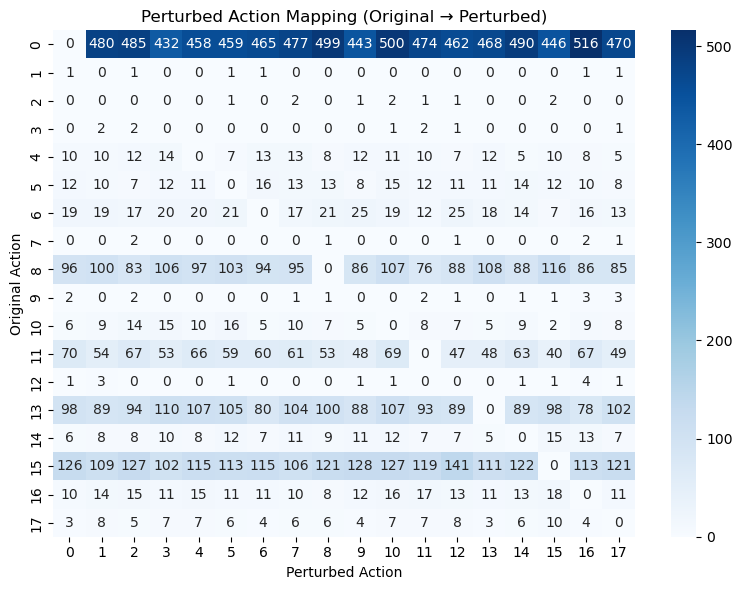

In [2]:
dataset_path = 'datasets/beginner_logs/seaquest_beginner_perturb10.pkl'
dataset = load_dataset(dataset_path)

info = inspect_dataset(dataset)
plot_perturbation_heatmap(dataset)

Total transitions            : 158089
Number of episodes (done=True): 18
Unique original actions       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Action counts (original)      : {9: 154, 15: 662, 2: 53467, 12: 1839, 5: 704, 3: 1212, 17: 4403, 7: 355, 16: 35517, 14: 526, 4: 37403, 13: 20297, 10: 537, 11: 265, 8: 114, 0: 85, 1: 218, 6: 331}
Number of perturbed actions   : 16093
Perturbation rate             : 10.180%


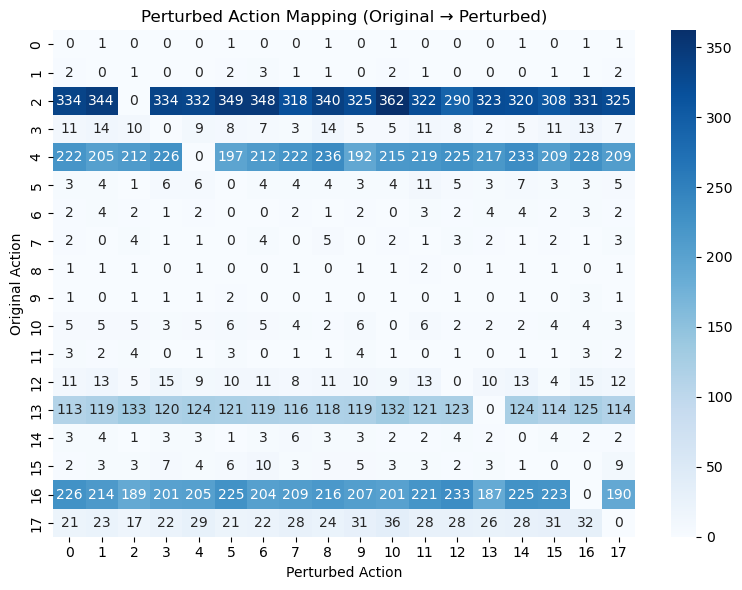

In [2]:
dataset_path = 'datasets/intermediate_logs/seaquest_intermediate_perturb10.pkl'
dataset = load_dataset(dataset_path)

info = inspect_dataset(dataset)
plot_perturbation_heatmap(dataset)

Total transitions            : 154171
Number of episodes (done=True): 21
Unique original actions       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Action counts (original)      : {6: 7838, 15: 10908, 12: 18326, 5: 6098, 16: 16087, 13: 9172, 7: 9436, 3: 21366, 14: 8430, 11: 12428, 2: 9743, 8: 4213, 9: 11167, 17: 3850, 10: 1312, 0: 1476, 4: 1444, 1: 877}
Number of perturbed actions   : 15709
Perturbation rate             : 10.189%


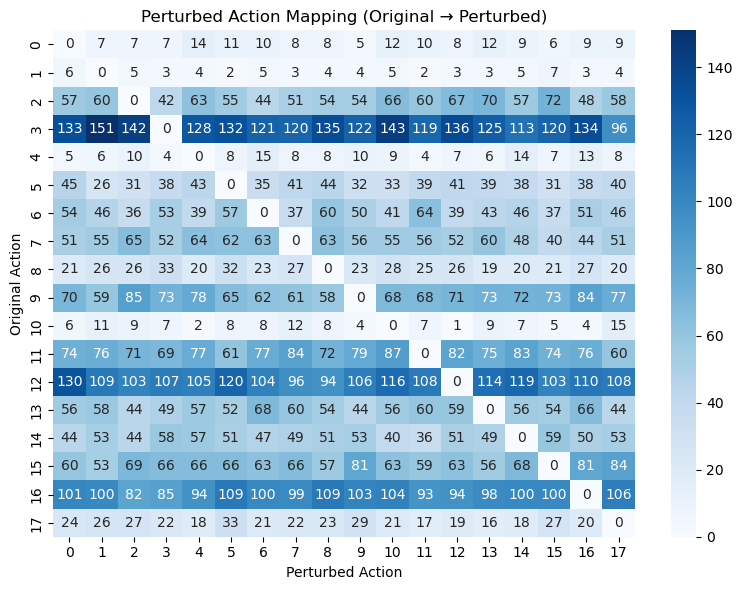

In [2]:
dataset_path = 'datasets/expert_logs/seaquest_expert_perturb10.pkl'
dataset = load_dataset(dataset_path)

info = inspect_dataset(dataset)
plot_perturbation_heatmap(dataset)

In [1]:
# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, generate_dataset, validate_dataset, evaluate_dqn_agent

In [2]:
dataset_paths = [        
    'datasets/beginner_logs/seaquest_beginner_perturb0.pkl',
    'datasets/beginner_logs/seaquest_beginner_perturb5.pkl',
    'datasets/beginner_logs/seaquest_beginner_perturb10.pkl',
    'datasets/beginner_logs/seaquest_beginner_perturb20.pkl',
]

for path in dataset_paths:
    print("="*60)
    validate_dataset(path)

seaquest_beginner_perturb0.pkl
    Total transitions      : 155813
    Perturbed actions      : 0
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 0.00%
Perturbation logic valid.

Episode Analysis for seaquest_beginner_perturb0.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 27
    ➤ Reward range         : 140.0 to 340.0
    ➤ Mean reward          : 245.93
    ➤ Episode Length range : 3297 to 8730
    ➤ Mean episode length  : 5770.85
    ➤ Last episode cut?    : No
    ➤ Last episode length  : N/A
seaquest_beginner_perturb5.pkl
    Total transitions      : 156685
    Perturbed actions      : 8009
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 5.11%
Perturbation logic valid.

Episode Analysis for seaquest_beginner_perturb5.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 25
    ➤ Reward range         : 100.0 to 400.0
    ➤ Mean reward          : 264.80
    ➤ Episode Len

In [2]:
dataset_paths = [        
    'datasets/intermediate_logs/seaquest_intermediate_perturb0.pkl',
    'datasets/intermediate_logs/seaquest_intermediate_perturb5.pkl',
    'datasets/intermediate_logs/seaquest_intermediate_perturb10.pkl',
    'datasets/intermediate_logs/seaquest_intermediate_perturb20.pkl',
]

for path in dataset_paths:
    print("="*60)
    validate_dataset(path)

seaquest_intermediate_perturb0.pkl
    Total transitions      : 158185
    Perturbed actions      : 0
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 0.00%
Perturbation logic valid.

Episode Analysis for seaquest_intermediate_perturb0.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 20
    ➤ Reward range         : 500.0 to 800.0
    ➤ Mean reward          : 664.00
    ➤ Episode Length range : 6342 to 9082
    ➤ Mean episode length  : 7909.25
    ➤ Last episode cut?    : No
    ➤ Last episode length  : N/A
seaquest_intermediate_perturb5.pkl
    Total transitions      : 157273
    Perturbed actions      : 8039
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 5.11%
Perturbation logic valid.

Episode Analysis for seaquest_intermediate_perturb5.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 18
    ➤ Reward range         : 680.0 to 800.0
    ➤ Mean reward          : 756.67
 

In [2]:
dataset_paths = [        
    'datasets/expert_logs/seaquest_expert_perturb0.pkl',
    'datasets/expert_logs/seaquest_expert_perturb5.pkl',
    'datasets/expert_logs/seaquest_expert_perturb10.pkl',
    'datasets/expert_logs/seaquest_expert_perturb20.pkl',
]

for path in dataset_paths:
    print("="*60)
    validate_dataset(path)

seaquest_expert_perturb0.pkl
    Total transitions      : 150305
    Perturbed actions      : 0
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 0.00%
Perturbation logic valid.

Episode Analysis for seaquest_expert_perturb0.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 20
    ➤ Reward range         : 540.0 to 1620.0
    ➤ Mean reward          : 1139.00
    ➤ Episode Length range : 4602 to 9685
    ➤ Mean episode length  : 7515.25
    ➤ Last episode cut?    : No
    ➤ Last episode length  : N/A
seaquest_expert_perturb5.pkl
    Total transitions      : 150697
    Perturbed actions      : 7689
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 5.10%
Perturbation logic valid.

Episode Analysis for seaquest_expert_perturb5.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 22
    ➤ Reward range         : 560.0 to 1560.0
    ➤ Mean reward          : 992.73
    ➤ Episode Length r